In [1]:
# import packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols, glm
import scipy.stats
from statsmodels.api import families

In [2]:
# set directory
main_directory = os.getcwd().strip('notebooks')

## Property internal features analysis 

In this Section we will be examining the correlation of property internal features, such as property type, number of beds/baths/parking to the rental price of the properties. Relevant features will be selected for modelling in the next stage

In [3]:
# read in cleaned rental properties
rental_data =pd.read_csv(main_directory+'data/curated/rental_properties_cleaned.csv')

In [4]:
# only want residential properties
rental_data = rental_data[(rental_data['property_type'] != 'storage unit') &(rental_data['property_type'] != 'Carspace')]

In [5]:
# drop irrelevant columns
rental_data.drop(columns = ['Unnamed: 0.1', 'index'], inplace = True)

In [6]:
# factorize certain columns
rental_data.share_flag = rental_data.share_flag.astype('category')

In [7]:
# examine the correlation between the internal attributes of rental property; numerical
corr = rental_data.corr()
corr.style.background_gradient(cmap='coolwarm')

,cost_text,beds,baths,parking,under 20 (%),20 - 39 (%),40 - 59 (%),60 +(%)
cost_text,1.000000,0.320863,0.424150,0.166420,-0.069596,-0.015882,0.047522,0.054644
beds,0.320863,1.000000,0.555679,0.498012,0.437816,-0.392116,0.167035,0.189110
baths,0.424150,0.555679,1.000000,0.348175,0.212736,-0.135217,0.073144,0.011129
parking,0.166420,0.498012,0.348175,1.000000,0.345164,-0.354583,0.194312,0.186673
under 20 (%),-0.069596,0.437816,0.212736,0.345164,1.000000,-0.687136,0.488667,0.051793
20 - 39 (%),-0.015882,-0.392116,-0.135217,-0.354583,-0.687136,1.000000,-0.629799,-0.699556
40 - 59 (%),0.047522,0.167035,0.073144,0.194312,0.488667,-0.629799,1.000000,0.099178
60 +(%),0.054644,0.189110,0.011129,0.186673,0.051793,-0.699556,0.099178,1.000000


Many of the features appear to be highly correlated with one another and not correlated with the response variable, we will drop all of these

In [8]:
# many of the features are correlated, we will drop correlated features that also have low correlation with response variable
rental_data.drop(columns = ['beds', 'parking', 'under 20 (%)', '20 - 39 (%)', '40 - 59 (%)', '60 +(%)'], inplace = True)

In [227]:
# correlation between categorical atts 
# function borrowed from https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
from scipy.stats import chi2_contingency
import association_metrics as am
# function to calculate cramer's v
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [228]:
# define categorical variables
rental_categorical = rental_data[['share_flag', 'property_type']].astype('category')

In [229]:
# Initialize a CramersV object 
cramers_v = am.CramersV(rental_categorical)
# It will return a pairwise matrix filled with Cramer's V, where 
# columns and index are the categorical variables of the passed     # pandas.DataFrame
cfit = cramers_v.fit().round(2)
cfit

,share_flag,property_type
share_flag,1.00,0.06
property_type,0.06,1.00


### Modelling (reduced)

The only features that remain after selection are: property type, share flag and number of bedrooms. We will explore these possible predictors with a few statistical models in this section 

In [230]:
# generate a simple linear model
fit_OLS = ols(
   formula = "cost_text ~ share_flag + property_type + baths", data = rental_data
).fit()

In [231]:
# check the fit of the model
fit_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              cost_text   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     128.7
Date:                Fri, 07 Oct 2022   Prob (F-statistic):          5.41e-290
Time:                        11:01:59   Log-Likelihood:                -45628.
No. Observations:                6583   AIC:                         9.128e+04
Df Residuals:                    6570   BIC:                         9.137e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                        436.2214    111.535      3.911      0.000     217.577     654.866
share_flag[T.1]                                  -98.9554     28.306     -3.496      0.000    -154.444     -43.467
property_type[T.Apartment / Unit / Flat]        -200.3164    111.110     -1.803      0.071    -418.129      17.496
property_type[T.Duplex]                         -344.3286    207.486     -1.660      0.097    -751.068      62.411
property_type[T.House]                          -220.8326    111.023     -1.989      0.047    -438.474      -3.191
property_type[T.New Apartments / Off the Plan]  -261.5250    207.475     -1.261      0.208    -668.243     145.193
property_type[T.Rural]                           166.7071    271.604      0.614      0.539    -365.725     699.140
property_type[T.Semi-Detached]                    -0.9357    150.209     -0.006      0.995    -295.394     293.522
property_type[T.Studio]                         -368.7591    113.854     -3.239      0.001    -591.950    -145.568
property_type[T.Terrace]                          -7.9102    145.264     -0.054      0.957    -292.675     276.854
property_type[T.Townhouse]                      -233.6338    111.299     -2.099      0.036    -451.816     -15.451
property_type[T.Villa]                          -242.0804    124.737     -1.941      0.052    -486.606       2.446
baths                                            198.5357      5.481     36.223      0.000     187.791     209.280
==============================================================================
Omnibus:                     7612.628   Durbin-Watson:                   0.338
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1266862.916
Skew:                           5.873   Prob(JB):                         0.00
Kurtosis:                      69.938   Cond. No.                         246.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

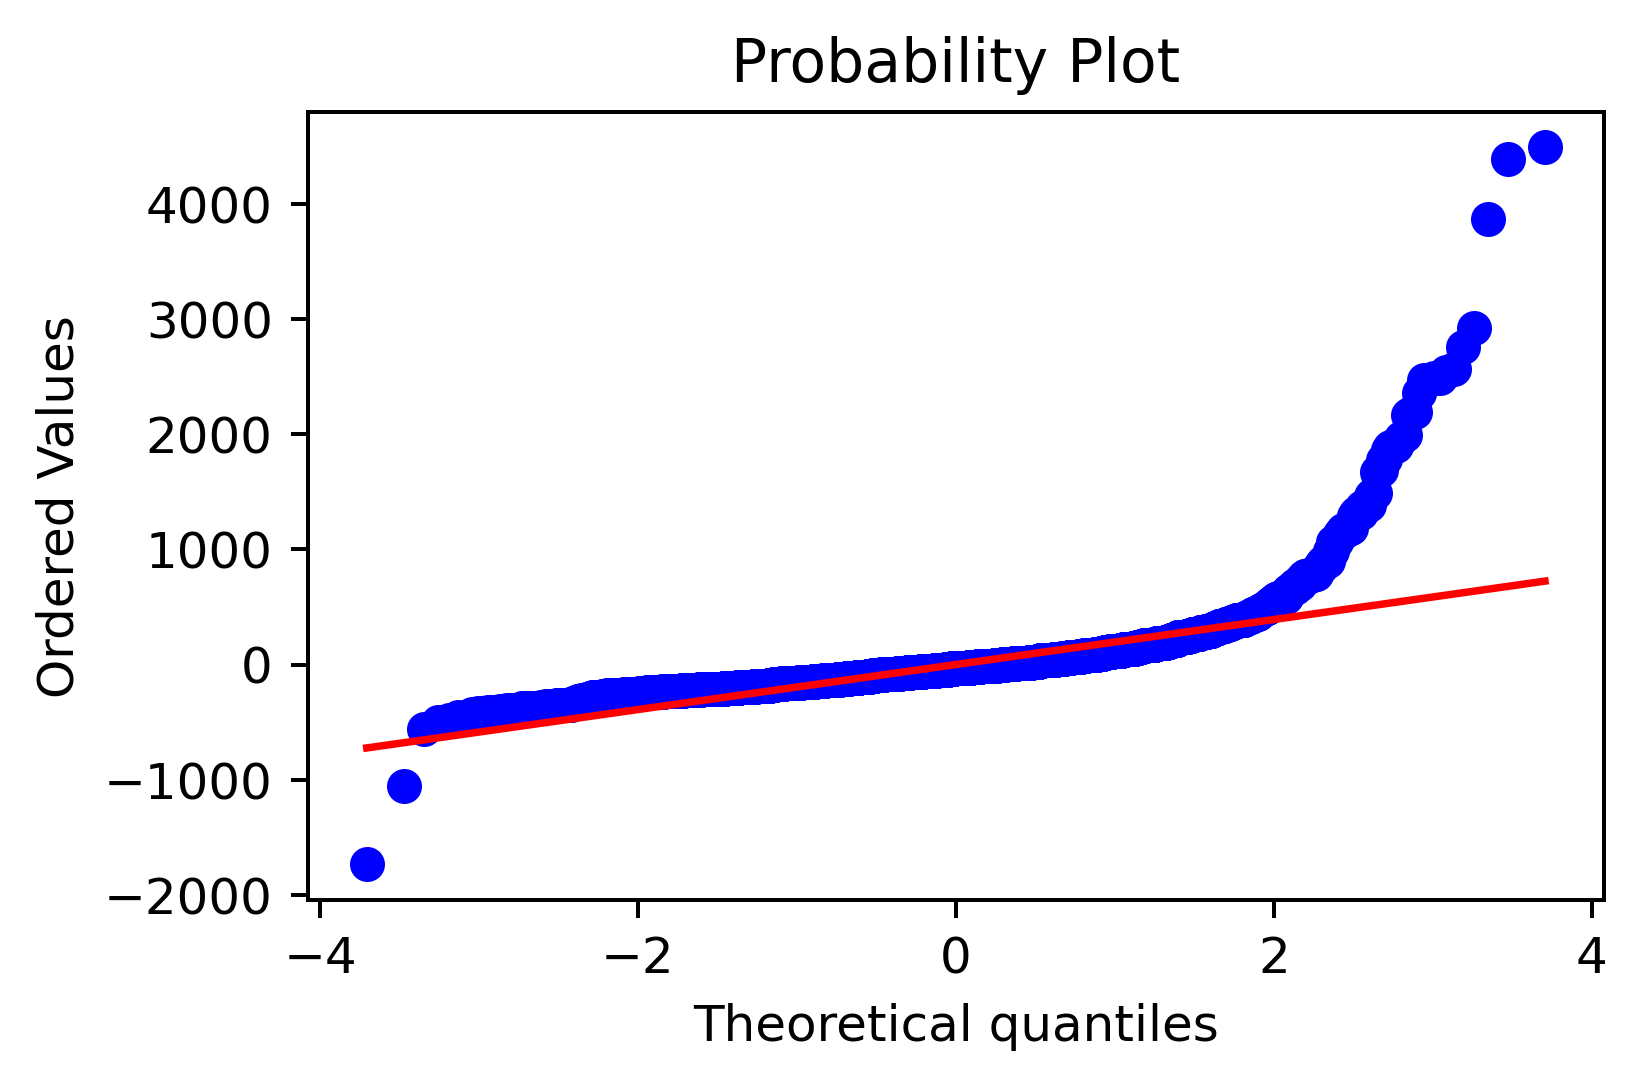

In [232]:
# plot residuals of the models
fig = plt.figure(figsize=(6,3))
headerfont = {'fontname':'Arial', 'fontsize':12}
plt.rcParams['figure.dpi'] = 360 # increase sharpness of chart
plt.gcf().subplots_adjust(bottom=0.15, left = 0.3)
ax = plt.subplot(111)
graph_DO = scipy.stats.probplot(fit_OLS.resid, plot=plt)

plt.show()

In [233]:
# residuals show heavy tails, perhaps a negative binomial model is more suitable?
fit_NB= glm(
    formula = "cost_text ~ share_flag + property_type + baths", data = rental_data,
    family=families.NegativeBinomial()
).fit()


In [234]:
fit_NB.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              cost_text   No. Observations:                 6583
Model:                            GLM   Df Residuals:                     6570
Model Family:        NegativeBinomial   Df Model:                           12
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -47453.
Date:                Fri, 07 Oct 2022   Deviance:                       760.94
Time:                        11:02:00   Pearson chi2:                 1.15e+03
No. Iterations:                     7   Pseudo R-squ. (CS):            0.04573
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                          6.1061      0.450     13.566      0.000       5.224       6.988
share_flag[T.1]                                   -0.2288      0.114     -2.001      0.045      -0.453      -0.005
property_type[T.Apartment / Unit / Flat]          -0.3454      0.448     -0.770      0.441      -1.224       0.533
property_type[T.Duplex]                           -0.4731      0.837     -0.565      0.572      -2.114       1.168
property_type[T.House]                            -0.3539      0.448     -0.790      0.430      -1.232       0.524
property_type[T.New Apartments / Off the Plan]    -0.4376      0.838     -0.523      0.601      -2.079       1.204
property_type[T.Rural]                             0.1647      1.096      0.150      0.881      -1.983       2.313
property_type[T.Semi-Detached]                     0.0041      0.606      0.007      0.995      -1.184       1.192
property_type[T.Studio]                           -0.8485      0.459     -1.846      0.065      -1.749       0.052
property_type[T.Terrace]                           0.0059      0.586      0.010      0.992      -1.143       1.155
property_type[T.Townhouse]                        -0.3707      0.449     -0.825      0.409      -1.251       0.510
property_type[T.Villa]                            -0.4253      0.503     -0.845      0.398      -1.412       0.561
baths                                              0.3185      0.022     14.394      0.000       0.275       0.362
==================================================================================================================
"""

In [235]:
# perform an anova on the linear regression model
anova_table = sm.stats.anova_lm(fit_OLS)

In [236]:
# from the anova table, it appears that all features selected in this section are significant
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
share_flag,1.0,1.300651e+06,1.300651e+06,21.158082,4.308443e-06
property_type,10.0,1.296873e+07,1.296873e+06,21.096616,3.845590e-39
baths,1.0,8.065802e+07,8.065802e+07,1312.087931,4.147619e-262
Residual,6570.0,4.038778e+08,6.147303e+04,NaN,NaN


This section's analysis and modelling results suggest that the number of baths, property type and whether the property is shared or not is significant to the rental prices of the property. However, it appears that the variables are too simplistic on their own as predictors. Hence we will explore other external factors but retain these three features for our final modelling

## SA2 specific features analysis

In [237]:
# read in all SA2 specific features
SA2_features_raw = pd.read_csv(main_directory+'data/curated/external_features(SA2).csv')

In [238]:
# replace string values
SA2_features_raw = SA2_features_raw.replace(['np'],'0')

# drop na values
SA2_features_raw.dropna(inplace = True)

In [239]:
# make a copy to look at numerical values
SA2_features = SA2_features_raw.copy()
# drop irrelevant columns
SA2_features.drop(columns = ['pop_2021', 'Unnamed: 0','property_type','LGA code','SA2 code','SA2 name'], inplace = True)

In [240]:
set(SA2_features_raw.property_type) # examine property types

{'Acreage / Semi-Rural',
 'Apartment / Unit / Flat',
 'Duplex',
 'House',
 'Rural',
 'Semi-Detached',
 'Studio',
 'Terrace',
 'Townhouse',
 'Villa'}

In [241]:
# convert all columns to numerical 
for column in SA2_features.columns:
    print(column)
    SA2_features[column]=SA2_features[column].astype(float)

index
cost_text
SA2 code_y
Area
Children_population
Early_Working_age_population
Prime_Working_age_population
Mature_Working_age_population
Elderly_population
2021 crime rate
SA2 CODE
Median $ 2019
Mean $ 2019


In [242]:
# examine the correlation between the internal attributes of rental property; numerical
corr_2 = SA2_features .corr()
corr_2.style.background_gradient(cmap='coolwarm')

,index,cost_text,SA2 code_y,Area,Children_population,Early_Working_age_population,Prime_Working_age_population,Mature_Working_age_population,Elderly_population,2021 crime rate,SA2 CODE,Median $ 2019,Mean $ 2019
index,1.000000,0.710141,-0.133699,-0.078062,-0.067853,-0.045401,0.007905,0.014297,-0.005780,0.083963,-0.133700,0.293963,0.332484
cost_text,0.710141,1.000000,-0.117183,-0.053244,-0.098241,-0.058956,-0.033446,0.023290,-0.032278,0.094645,-0.117184,0.217546,0.285389
SA2 code_y,-0.133699,-0.117183,1.000000,-0.002179,0.308090,0.036932,0.114690,0.084260,0.150335,-0.204407,1.000000,-0.174783,-0.281145
Area,-0.078062,-0.053244,-0.002179,1.000000,-0.066948,-0.143209,-0.179730,0.018418,-0.122788,-0.051292,-0.002178,-0.149585,-0.117593
Children_population,-0.067853,-0.098241,0.308090,-0.066948,1.000000,0.461968,0.612009,0.513033,0.763762,-0.449693,0.308091,-0.075987,-0.191118
Early_Working_age_population,-0.045401,-0.058956,0.036932,-0.143209,0.461968,1.000000,0.666602,0.358664,0.719141,0.073924,0.036931,-0.263296,-0.115203
Prime_Working_age_population,0.007905,-0.033446,0.114690,-0.179730,0.612009,0.666602,1.000000,0.377268,0.841241,-0.011264,0.114691,0.090947,-0.020748
Mature_Working_age_population,0.014297,0.023290,0.084260,0.018418,0.513033,0.358664,0.377268,1.000000,0.768916,-0.404294,0.084262,-0.193024,-0.076746
Elderly_population,-0.005780,-0.032278,0.150335,-0.122788,0.763762,0.719141,0.841241,0.768916,1.000000,-0.269660,0.150337,-0.107876,-0.085617
2021 crime rate,0.083963,0.094645,-0.204407,-0.051292,-0.449693,0.073924,-0.011264,-0.404294,-0.269660,1.000000,-0.204411,0.132043,0.209057


In [243]:
# view all the property types
set(SA2_features_raw.property_type)

{'Acreage / Semi-Rural',
 'Apartment / Unit / Flat',
 'Duplex',
 'House',
 'Rural',
 'Semi-Detached',
 'Studio',
 'Terrace',
 'Townhouse',
 'Villa'}

Disappointingly, only mean income seem to be moderately correlated with rental prices, so we will only keep this feature for the final modelling

In [244]:
# we will now examine how the SA2 featuers are correlated when it comes to mean and median SA2 rental prices
mean_price = SA2_features_raw.groupby('SA2 name')['cost_text'].mean()
median_price = SA2_features_raw.groupby('SA2 name')['cost_text'].median()

In [245]:
# create a new dataframe to get SA2 specific features only
SA2_data = pd.DataFrame()
SA2_data['mean price'] = mean_price
SA2_data['median price']=median_price 

# iterate through dataframe and get SA2 features
for column in SA2_features_raw.iloc[[],8:]: 
    print(column)
    # convert to float
    SA2_features_raw[column] = SA2_features_raw[column].astype(float)
    # get SA2 features
    SA2_data = SA2_data.merge(SA2_features_raw.groupby('SA2 name')[column].first(),how='left', left_index=True, right_index=True)

pop_2021
Area
Children_population
Early_Working_age_population
Prime_Working_age_population
Mature_Working_age_population
Elderly_population
2021 crime rate
SA2 CODE
Median $ 2019
Mean $ 2019


In [246]:
# plot correlation matrixes
# examine the correlation between the internal attributes of rental property; numerical
corr_3 = SA2_data.corr()
corr_3.style.background_gradient(cmap='coolwarm')

,mean price,median price,pop_2021,Area,Children_population,Early_Working_age_population,Prime_Working_age_population,Mature_Working_age_population,Elderly_population,2021 crime rate,SA2 CODE,Median $ 2019,Mean $ 2019
mean price,1.000000,0.910797,0.009936,-0.184313,-0.067321,-0.005985,0.006502,0.070761,0.021910,0.038562,-0.125274,0.414635,0.550382
median price,0.910797,1.000000,-0.014101,-0.166163,-0.057036,-0.022896,-0.021859,0.041651,-0.005418,-0.043406,-0.117009,0.351651,0.448285
pop_2021,0.009936,-0.014101,1.000000,-0.268136,0.893963,0.897847,0.957137,0.776704,0.994214,-0.120949,0.130429,0.102487,0.046172
Area,-0.184313,-0.166163,-0.268136,1.000000,-0.233956,-0.294546,-0.298766,-0.078553,-0.255045,-0.017041,-0.000456,-0.311708,-0.209904
Children_population,-0.067321,-0.057036,0.893963,-0.233956,1.000000,0.776332,0.847534,0.594543,0.865828,-0.240087,0.198608,0.102760,-0.045456
Early_Working_age_population,-0.005985,-0.022896,0.897847,-0.294546,0.776332,1.000000,0.866628,0.612759,0.878974,-0.015631,0.119197,0.065417,0.060770
Prime_Working_age_population,0.006502,-0.021859,0.957137,-0.298766,0.847534,0.866628,1.000000,0.605204,0.928216,-0.012844,0.131895,0.213479,0.095924
Mature_Working_age_population,0.070761,0.041651,0.776704,-0.078553,0.594543,0.612759,0.605204,1.000000,0.825209,-0.236848,0.040327,-0.114298,-0.024309
Elderly_population,0.021910,-0.005418,0.994214,-0.255045,0.865828,0.878974,0.928216,0.825209,1.000000,-0.137797,0.116035,0.070241,0.043399
2021 crime rate,0.038562,-0.043406,-0.120949,-0.017041,-0.240087,-0.015631,-0.012844,-0.236848,-0.137797,1.000000,-0.096298,0.115220,0.160405


It looks like mean price is highly correlated with the mean SA2 rental prices, we will also potentially fit models with other moderately correlated variables

## POIs analysis

### Preliminaries

In [3]:
from numpy import arange
import matplotlib.pyplot as plt
from itertools import chain
import statsmodels.api as sm
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_validate

In [5]:
# Read in POI counts data
df = pd.read_csv(main_directory+'data/curated/poi_counts.csv',index_col=0)

In [14]:
dist_df = pd.read_csv(main_directory+'data/curated/distance.csv',index_col=0)

In [15]:
dist_df

,coordinates,distance,duration
0,"[-36.253557, 144.944557]",219148.5,10568.7
1,"[-36.554159, 146.7208003]",292009.2,12243.3
2,"[-36.5530096, 146.7188613]",292171.1,12257.9
3,"[-36.5380049, 145.9927626]",211239.3,9285.7
4,"[-36.5424309, 145.9979175]",210269.4,9193.0
...,...,...,...
6595,"[-37.8223967, 144.938237]",3255.7,389.8
6596,"[-37.8301164, 144.9569041]",1997.0,243.4
6597,"[-37.8141725, 144.9740049]",5337.6,629.4
6598,"[-38.372703, 144.7856897]",108866.0,5254.4


In [7]:
# Read in category types
with open(main_directory+'/data/curated/poi_types.txt', 'r') as fp:
    ls = fp.read().splitlines()

In [8]:
df

,coordinates,pitch,water,school,swimming_pool,parking,social_facility,fuel,mall,hardware,...,volcano,garden_furniture,swimming_area,heliport,summer_camp,brewing_supplies,perfumery,pillory,fort,cost
0,"[-36.253557, 144.944557]",12.0,16.0,2.0,8.0,6.0,4.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.000000
1,"[-36.554159, 146.7208003]",47.0,23.0,3.0,19.0,16.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.923077
2,"[-36.5530096, 146.7188613]",47.0,21.0,3.0,18.0,16.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.384615
3,"[-36.5380049, 145.9927626]",7.0,9.0,3.0,1.0,21.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.000000
4,"[-36.5424309, 145.9979175]",5.0,15.0,3.0,1.0,21.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5973,"[-37.8802849, 147.8299957]",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,720.000000
5974,"[-37.8791032, 147.8273685]",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,720.000000
5975,"[-38.1336473, 144.7061689]",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,725.000000
5976,"[-38.372703, 144.7856897]",0.0,0.0,0.0,0.0,8.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,725.000000


In [17]:
df_full = pd.concat([df, dist_df], join='inner', ignore_index=True, axis=1).drop(columns=[272])

In [19]:
columns = [['coordinates'], ls, ['cost'], ['distance', 'duration']]
columns = list(chain.from_iterable(columns))

In [21]:
df_full.set_axis(columns, axis=1, inplace=True)

C:\Users\aranw\AppData\Local\Temp\ipykernel_12720\2140439761.py:1: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_full.set_axis(columns, axis=1, inplace=True)


In [25]:
df_full.dropna(inplace=True)

In [35]:
# Reorder the columns
df_full = df_full[chain.from_iterable([['coordinates'],['distance', 'duration'], ls, ['cost']])]

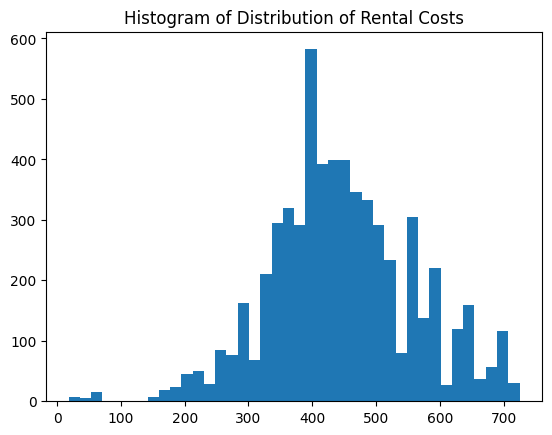

In [27]:
plt.hist(df_full['cost'], bins = 40)
plt.title('Histogram of Distribution of Rental Costs')
plt.savefig(main_directory+'models/cost_hist.png')

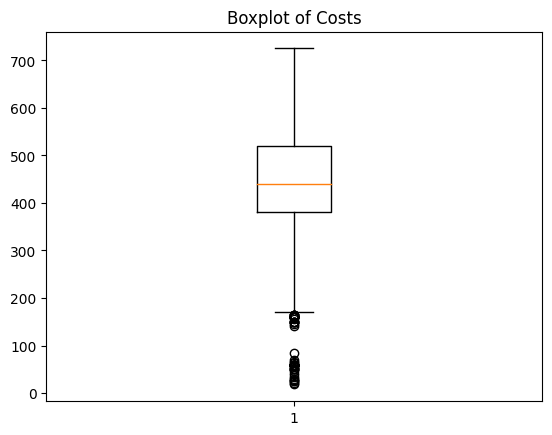

In [28]:
plt.boxplot(df_full['cost'])
plt.title('Boxplot of Costs')
plt.savefig(main_directory+'models/cost_boxplot.png')

#### From the 2 plots, we can see that there are a lot of outliers with low costs. They may be associated with the many storage units in listing.

### OLS Regression based on POI

In [37]:
def get_stats():
    x = df_full[chain.from_iterable([['distance', 'duration'], ls])]
    y = df_full['cost']
    results = sm.OLS(y, x).fit()
    print(results.summary())

In [38]:
get_stats()

                                 OLS Regression Results                                
Dep. Variable:                   cost   R-squared (uncentered):                   0.872
Model:                            OLS   Adj. R-squared (uncentered):              0.866
Method:                 Least Squares   F-statistic:                              142.9
Date:                Tue, 04 Oct 2022   Prob (F-statistic):                        0.00
Time:                        12:22:31   Log-Likelihood:                         -38975.
No. Observations:                5975   AIC:                                  7.849e+04
Df Residuals:                    5703   BIC:                                  8.032e+04
Df Model:                         272                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

The OLS model has a R^2 of 0.825, which is really good. However, it uses all the features, which loses out on generalisation.

### Modelling (reduced)

We now try and fit an elastic net regression model on the data.

#### Perform a grid search through values for alpha and penalty parameters of elastic net to find optimal values.

In [39]:
X, y = df_full.iloc[:,1:-1], df_full.iloc[:,-1]
model = ElasticNet()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1)
# define grid
grid = dict()
grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid['l1_ratio'] = arange(0, 1, 0.1)
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=2)
# perform the search
results = search.fit(X, y)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: -80.733
Config: {'alpha': 0.1, 'l1_ratio': 0.0}


c:\Users\aranw\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.088e+07, tolerance: 7.634e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


### Create the elastic net model with optimal parameters

In [40]:
x = df_full[ls]
y = df_full['cost']

In [41]:
# Scale the columns
scaler = StandardScaler()
df_scaled = scaler.fit_transform(x)

In [44]:
net = ElasticNet(random_state=0, alpha=0.1, l1_ratio=0)
results_cv = cross_validate(net, df_scaled, y, cv=10, n_jobs=2, scoring='r2')
pd.DataFrame(results_cv).to_json(main_directory +'data/curated/CVresultsEnet.csv')

In [43]:
results_cv

{'fit_time': array([1.0164361 , 1.04443932, 1.0793469 , 1.09534502, 1.03380513,
        1.04182339, 1.04035234, 1.02933431, 1.06788683, 1.0578711 ]),
 'score_time': array([0.00099945, 0.00100017, 0.00099778, 0.00100112, 0.00099659,
        0.0009954 , 0.00099349, 0.00099921, 0.00098872, 0.00099158]),
 'test_score': array([-11.37920945, -64.73304449, -68.94739428, -96.60324286,
        -59.5633422 , -55.90323471, -22.16326593, -29.97560727,
        -40.56445727, -39.33872295])}

We can see that the variance of the R^2 value across the validation runs is very high.

In [45]:
net.fit(df_scaled,y)

c:\Users\aranw\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.198e+07, tolerance: 7.634e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


ElasticNet(alpha=0.1, l1_ratio=0, random_state=0)

In [46]:
coefs = net.coef_
remove_list = []
for i in range(len(coefs)):
    if abs(coefs[i]) < 0.05:
        remove_list.append(ls[i])

In [47]:
remove_list

['bar', 'erotic', 'radiotechnics']

In [48]:
len(remove_list)

3

In [53]:
columns = list(chain.from_iterable([['coordinates'], ['distance', 'duration'],ls]))

In [55]:
df_reduce = df_full[columns].drop(remove_list, axis=1)

In [56]:
df_unique = pd.DataFrame(df_reduce.nunique(), columns=['Counts'])

In [57]:
df_unique[df_unique['Counts'] <= 5]

,Counts
agrarian,4
aerodrome,3
theme_park,4
locksmith,5
coworking_space,4
...,...
summer_camp,2
brewing_supplies,2
perfumery,2
pillory,2


#### There are quite a lot of features with few unique values. Most of these could be noise to the data, and will need to be filtered out.

In [78]:
remove_list = list(df_unique[df_unique['Counts'] <= 5].index)

In [79]:
df_reduce = df_reduce.drop(remove_list, axis=1)

In [80]:
df_reduce

,coordinates,pitch,water,school,swimming_pool,parking,social_facility,fuel,mall,hardware,...,curtain,zoo,dojo,cannon,retirement_home,general,tiles,bird_hide,estate_agent,bus_station
0,"[-36.253557, 144.944557]",12.0,16.0,2.0,8.0,6.0,4.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"[-36.554159, 146.7208003]",47.0,23.0,3.0,19.0,16.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"[-36.5530096, 146.7188613]",47.0,21.0,3.0,18.0,16.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"[-36.5380049, 145.9927626]",7.0,9.0,3.0,1.0,21.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"[-36.5424309, 145.9979175]",5.0,15.0,3.0,1.0,21.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5973,"[-37.8802849, 147.8299957]",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5974,"[-37.8791032, 147.8273685]",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5975,"[-38.1336473, 144.7061689]",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5976,"[-38.372703, 144.7856897]",0.0,0.0,0.0,0.0,8.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
# For further testing if required
#df_unique2 = pd.DataFrame(df_reduce.nunique(), columns=['Counts'])

In [83]:
df_reduce.to_csv(main_directory+'data/curated/reduced_POI_optimal_v2.csv')

## Final modelling (all relevant features)

### OLS model

In [247]:
# drop irrelevant columns
SA2_data.drop(columns = ['Median $ 2019','SA2 CODE'], inplace = True)

In [248]:
# rename variable so it can be joined
SA2_data.rename(columns = {'mean price':'mean_price', 'Mean $ 2019': 'Mean_income_2019', '2021 crime rate': 'crime_rate_2021'}, inplace = True)

In [249]:
# segregate all features columns
features_names = list(SA2_data.iloc[[],2:].columns)

In [250]:
features_names

['pop_2021',
 'Area',
 'Children_population',
 'Early_Working_age_population',
 'Prime_Working_age_population',
 'Mature_Working_age_population',
 'Elderly_population',
 'crime_rate_2021',
 'Mean_income_2019']

In [251]:
# generate a simple linear model
OLS_SA2 = ols(
   formula = "np.log(mean_price) ~ " + ' + '.join(features_names), data = SA2_data
).fit()

In [252]:
OLS_SA2.summary() # summarise model fit

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(mean_price)   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     22.17
Date:                Fri, 07 Oct 2022   Prob (F-statistic):           1.37e-26
Time:                        11:02:12   Log-Likelihood:                 71.983
No. Observations:                 314   AIC:                            -126.0
Df Residuals:                     305   BIC:                            -92.22
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         5.6516      0.063     90.400      0.000       5.529       5.775
pop_2021                       8.726e-06   1.78e-05      0.492      0.623   -2.62e-05    4.37e-05
Area                           -2.86e-05   1.01e-05     -2.827      0.005   -4.85e-05    -8.7e-06
Children_population           -1.845e-05   1.82e-05     -1.013      0.312   -5.43e-05    1.74e-05
Early_Working_age_population    -2.1e-05   2.82e-05     -0.743      0.458   -7.66e-05    3.46e-05
Prime_Working_age_population  -5.267e-06   1.31e-05     -0.401      0.689   -3.11e-05    2.06e-05
Mature_Working_age_population  6.816e-05   4.72e-05      1.444      0.150   -2.47e-05       0.000
Elderly_population            -5.996e-06   2.21e-05     -0.272      0.786   -4.94e-05    3.74e-05
crime_rate_2021                  -0.3324      0.492     -0.675      0.500      -1.301       0.637
Mean_income_2019               8.233e-06   7.06e-07     11.667      0.000    6.84e-06    9.62e-06
==============================================================================
Omnibus:                       61.971   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              149.713
Skew:                           0.949   Prob(JB):                     3.09e-33
Kurtosis:                       5.800   Cond. No.                     1.96e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.94e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [253]:
# perform anova to assess variables 
anova_table_2 = sm.stats.anova_lm(OLS_SA2)

In [254]:
anova_table_2

,df,sum_sq,mean_sq,F,PR(>F)
pop_2021,1.0,0.046441,0.046441,1.218617,2.705023e-01
Area,1.0,0.888215,0.888215,23.306786,2.187802e-06
Children_population,1.0,0.517988,0.517988,13.592024,2.688009e-04
Early_Working_age_population,1.0,0.096951,0.096951,2.543984,1.117508e-01
Prime_Working_age_population,1.0,0.011287,0.011287,0.296177,5.866869e-01
Mature_Working_age_population,1.0,0.011545,0.011545,0.302930,5.824545e-01
Elderly_population,1.0,0.047159,0.047159,1.237450,2.668390e-01
crime_rate_2021,1.0,0.000011,0.000011,0.000280,9.866679e-01
Mean_income_2019,1.0,5.180805,5.180805,135.944407,3.155130e-26
Residual,305.0,11.623469,0.038110,NaN,NaN


only mean income seems to be significant for forecasting population

### Negative Binomial

In [255]:
# generate a NB model
NB_SA2 = glm(
   formula = "np.log(mean_price) ~ " + ' + '.join(features_names), data = SA2_data,
family = families.NegativeBinomial()
).fit()

In [256]:
NB_SA2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:     np.log(mean_price)   No. Observations:                  314
Model:                            GLM   Df Residuals:                      305
Model Family:        NegativeBinomial   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -909.10
Date:                Fri, 07 Oct 2022   Deviance:                      0.26006
Time:                        11:02:14   Pearson chi2:                    0.264
No. Iterations:                     3   Pseudo R-squ. (CS):          0.0004811
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         1.7361      0.345      5.038      0.000       1.061       2.411
pop_2021                       1.394e-06    9.8e-05      0.014      0.989      -0.000       0.000
Area                          -4.682e-06    5.6e-05     -0.084      0.933      -0.000       0.000
Children_population           -3.012e-06      0.000     -0.030      0.976      -0.000       0.000
Early_Working_age_population  -3.362e-06      0.000     -0.022      0.983      -0.000       0.000
Prime_Working_age_population  -8.081e-07   7.26e-05     -0.011      0.991      -0.000       0.000
Mature_Working_age_population  1.092e-05      0.000      0.042      0.967      -0.000       0.001
Elderly_population            -9.533e-07      0.000     -0.008      0.994      -0.000       0.000
crime_rate_2021                  -0.0549      2.718     -0.020      0.984      -5.382       5.272
Mean_income_2019               1.323e-06   3.88e-06      0.341      0.733   -6.29e-06    8.93e-06
=================================================================================================
"""

it seems that a OLS is more appropriate with only income as the only predictor

### testing

In this section we will be testing OLS and NB models through cross validation

In [257]:
# reset index
SA2_data.reset_index(inplace = True)

In [258]:
SA2_data

,SA2 name,mean_price,median price,pop_2021,Area,Children_population,Early_Working_age_population,Prime_Working_age_population,Mature_Working_age_population,Elderly_population,crime_rate_2021,Mean_income_2019
0,Abbotsford,572.679045,575.0,9262.0,1.7,759.0,905.0,6450.0,578.0,9832.0,0.118272,78181.0
1,Airport West,409.000000,400.0,8237.0,3.7,1384.0,762.0,4102.0,797.0,9429.0,0.049673,65204.0
2,Albert Park,700.882353,535.0,16023.0,4.7,2165.0,1470.0,8541.0,1731.0,18139.0,0.098302,120412.0
3,Alexandra,350.000000,350.0,6768.0,2119.0,910.0,531.0,2601.0,1258.0,8236.0,0.043809,48414.0
4,Alfredton,423.421053,420.0,16823.0,52.7,4075.0,2391.0,7550.0,1375.0,18255.0,0.063340,63668.0
...,...,...,...,...,...,...,...,...,...,...,...,...
309,Yarram,327.500000,327.5,5556.0,1931.9,777.0,470.0,2122.0,1098.0,6645.0,0.070800,48524.0
310,Yarraville,560.571429,540.0,15653.0,5.6,3024.0,1439.0,8874.0,1172.0,16797.0,0.081576,83130.0
311,Yarrawonga,451.666667,495.0,8585.0,94.7,1364.0,752.0,2986.0,1367.0,10701.0,0.053705,49703.0
312,Yarriambiack,307.500000,307.5,6454.0,7139.6,1015.0,586.0,2412.0,1105.0,7790.0,0.075221,52472.0


In [265]:

# plot the relationship between mean income and mean price
plt.scatter(SA2_data['Mean_income_2019'],SA2_data['mean_price'])
plt.title('Average rental prices vs Average income for each SA2')
plt.xlabel('Average income')
plt.ylabel('Average rental prices')
plt.savefig(main_directory + 'plots/price income.png')
plt.close()

In [260]:
# list to store error rates
OLS_error = []
NB_error = []

# we will perform a one part out cross validation 
for i in range(len(SA2_data)):
    # take out one part for testing
    test = SA2_data.iloc[[i],]
    # rest for training
    train = SA2_data[SA2_data.index !=i]
    
    # fit OLS model 
    OLS_income = ols(
       formula = "np.log(mean_price) ~ Mean_income_2019", data = train,
    family = families.NegativeBinomial()
        ).fit()
    # fit NB model
    NB_income =glm(
   formula = "np.log(mean_price) ~ Mean_income_2019", data = train,
    family = families.NegativeBinomial()
    ).fit()
    
    # output accuracy scores into pd frame '
    OLS_error.append(float(np.exp(OLS_income.predict(test)) - test['mean_price']))
    NB_error.append(float(np.exp(NB_income.predict(test)) - test['mean_price']))




/Users/lucyliu/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)
/Users/lucyliu/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)
/Users/lucyliu/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)
/Users/lucyliu/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)
/Users/lucyliu/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)
/Users/lucyliu/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)
/Users/luc

In [261]:
# create pandas frame to store results
Results_CV = pd.DataFrame()

# write results error in

Results_CV['OLS error'] = OLS_error
Results_CV['NB error'] = NB_error

In [262]:
# change all to absolute values
Results_CV['OLS error'] = abs(Results_CV['OLS error'])
Results_CV['NB error'] = abs(Results_CV['NB error'])

In [263]:
# examine the errors -OLS
print('median of OLS errors is', Results_CV['OLS error'].median())
print('sd of OLS errors is', Results_CV['OLS error'].std())

median of OLS errors is 46.68616100932343
sd of OLS errors is 94.4290103157687


In [264]:
# examine NB errors
print('median of NB errors is', Results_CV['NB error'].median())
print('sd of NB errors is', Results_CV['NB error'].std())

median of NB errors is 47.32631547896685
sd of NB errors is 99.46672253765189


the OLS model seems to be a better fit in this case, so we will use this for our forecasts

## Future data

In [139]:
# read in future data for income
future_income_data=pd.read_csv(main_directory+'data/curated/forecast_income_SA2.csv')

In [140]:
future_income_data.sort_values(by = ['SA2_NAME'])

,Unnamed: 0,SA2_NAME,2020,2021,2022,2023,2024,2025
0,0,Abbotsford,81603.0,85174.8,88902.9,92794.2,96855.8,101095.2
1,1,Airport West,67662.9,70214.6,72862.5,75610.2,78461.6,81420.5
2,2,Albert Park,122800.0,125235.4,127719.1,130252.0,132835.2,135469.5
3,3,Alexandra,50193.7,52038.9,53951.9,55935.2,57991.5,60123.3
4,4,Alfredton,65636.4,67665.6,69757.6,71914.3,74137.6,76429.7
...,...,...,...,...,...,...,...,...
457,457,Yarram,49889.2,51292.7,52735.8,54219.5,55744.9,57313.2
458,458,Yarraville,86502.6,90012.0,93663.8,97463.8,101417.9,105532.5
459,459,Yarrawonga,50606.0,51525.5,52461.6,53414.8,54385.2,55373.4
460,460,Yarriambiack,56678.5,61222.3,66130.4,71431.9,77158.4,83344.0


In [141]:
SA2_data

,index,SA2 name,mean_price,median price,pop_2021,Area,Children_population,Early_Working_age_population,Prime_Working_age_population,Mature_Working_age_population,Elderly_population,crime_rate_2021,Mean_income
0,0,Abbotsford,572.679045,575.0,9262.0,1.7,759.0,905.0,6450.0,578.0,9832.0,0.118272,78181.0
1,1,Airport West,409.000000,400.0,8237.0,3.7,1384.0,762.0,4102.0,797.0,9429.0,0.049673,65204.0
2,2,Albert Park,700.882353,535.0,16023.0,4.7,2165.0,1470.0,8541.0,1731.0,18139.0,0.098302,120412.0
3,3,Alexandra,350.000000,350.0,6768.0,2119.0,910.0,531.0,2601.0,1258.0,8236.0,0.043809,48414.0
4,4,Alfredton,423.421053,420.0,16823.0,52.7,4075.0,2391.0,7550.0,1375.0,18255.0,0.063340,63668.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,309,Yarram,327.500000,327.5,5556.0,1931.9,777.0,470.0,2122.0,1098.0,6645.0,0.070800,48524.0
310,310,Yarraville,560.571429,540.0,15653.0,5.6,3024.0,1439.0,8874.0,1172.0,16797.0,0.081576,83130.0
311,311,Yarrawonga,451.666667,495.0,8585.0,94.7,1364.0,752.0,2986.0,1367.0,10701.0,0.053705,49703.0
312,312,Yarriambiack,307.500000,307.5,6454.0,7139.6,1015.0,586.0,2412.0,1105.0,7790.0,0.075221,52472.0


In [142]:
SA2_data.reset_index(inplace = True)

In [143]:
# new df with only relevant data
SA2_data_relevant = pd.DataFrame()
SA2_data_relevant['SA2'] = SA2_data['SA2 name']
SA2_data_relevant['mean_price']=SA2_data['mean_price']

In [144]:
# merge df
future_income_data=future_income_data.merge(SA2_data_relevant, how = 'inner', left_on = 'SA2_NAME', right_on = 'SA2')

In [145]:
future_income_data

,Unnamed: 0,SA2_NAME,2020,2021,2022,2023,2024,2025,SA2,mean_price
0,0,Abbotsford,81603.0,85174.8,88902.9,92794.2,96855.8,101095.2,Abbotsford,572.679045
1,1,Airport West,67662.9,70214.6,72862.5,75610.2,78461.6,81420.5,Airport West,409.000000
2,2,Albert Park,122800.0,125235.4,127719.1,130252.0,132835.2,135469.5,Albert Park,700.882353
3,3,Alexandra,50193.7,52038.9,53951.9,55935.2,57991.5,60123.3,Alexandra,350.000000
4,4,Alfredton,65636.4,67665.6,69757.6,71914.3,74137.6,76429.7,Alfredton,423.421053
...,...,...,...,...,...,...,...,...,...,...
309,457,Yarram,49889.2,51292.7,52735.8,54219.5,55744.9,57313.2,Yarram,327.500000
310,458,Yarraville,86502.6,90012.0,93663.8,97463.8,101417.9,105532.5,Yarraville,560.571429
311,459,Yarrawonga,50606.0,51525.5,52461.6,53414.8,54385.2,55373.4,Yarrawonga,451.666667
312,460,Yarriambiack,56678.5,61222.3,66130.4,71431.9,77158.4,83344.0,Yarriambiack,307.500000


In [146]:
future_income_data

,Unnamed: 0,SA2_NAME,2020,2021,2022,2023,2024,2025,SA2,mean_price
0,0,Abbotsford,81603.0,85174.8,88902.9,92794.2,96855.8,101095.2,Abbotsford,572.679045
1,1,Airport West,67662.9,70214.6,72862.5,75610.2,78461.6,81420.5,Airport West,409.000000
2,2,Albert Park,122800.0,125235.4,127719.1,130252.0,132835.2,135469.5,Albert Park,700.882353
3,3,Alexandra,50193.7,52038.9,53951.9,55935.2,57991.5,60123.3,Alexandra,350.000000
4,4,Alfredton,65636.4,67665.6,69757.6,71914.3,74137.6,76429.7,Alfredton,423.421053
...,...,...,...,...,...,...,...,...,...,...
309,457,Yarram,49889.2,51292.7,52735.8,54219.5,55744.9,57313.2,Yarram,327.500000
310,458,Yarraville,86502.6,90012.0,93663.8,97463.8,101417.9,105532.5,Yarraville,560.571429
311,459,Yarrawonga,50606.0,51525.5,52461.6,53414.8,54385.2,55373.4,Yarrawonga,451.666667
312,460,Yarriambiack,56678.5,61222.3,66130.4,71431.9,77158.4,83344.0,Yarriambiack,307.500000


In [147]:
future_income_data.dropna() # are there anymore NA values

,Unnamed: 0,SA2_NAME,2020,2021,2022,2023,2024,2025,SA2,mean_price
0,0,Abbotsford,81603.0,85174.8,88902.9,92794.2,96855.8,101095.2,Abbotsford,572.679045
1,1,Airport West,67662.9,70214.6,72862.5,75610.2,78461.6,81420.5,Airport West,409.000000
2,2,Albert Park,122800.0,125235.4,127719.1,130252.0,132835.2,135469.5,Albert Park,700.882353
3,3,Alexandra,50193.7,52038.9,53951.9,55935.2,57991.5,60123.3,Alexandra,350.000000
4,4,Alfredton,65636.4,67665.6,69757.6,71914.3,74137.6,76429.7,Alfredton,423.421053
...,...,...,...,...,...,...,...,...,...,...
309,457,Yarram,49889.2,51292.7,52735.8,54219.5,55744.9,57313.2,Yarram,327.500000
310,458,Yarraville,86502.6,90012.0,93663.8,97463.8,101417.9,105532.5,Yarraville,560.571429
311,459,Yarrawonga,50606.0,51525.5,52461.6,53414.8,54385.2,55373.4,Yarrawonga,451.666667
312,460,Yarriambiack,56678.5,61222.3,66130.4,71431.9,77158.4,83344.0,Yarriambiack,307.500000


In [148]:
# rename columns 
for i in range(2020,2026): 
    future_income_data=future_income_data.rename(columns = {str(i): 'Mean_income_' + str(i)})

In [153]:
# let's fit the model with the 2022 data
OLS_SA2_2022 = ols(
   formula = "mean_price ~ Mean_income_2021", data = future_income_data
).fit()

In [154]:
OLS_SA2_2022.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             mean_price   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     133.7
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           5.57e-26
Time:                        17:10:46   Log-Likelihood:                -1919.5
No. Observations:                 314   AIC:                             3843.
Df Residuals:                     312   BIC:                             3850.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          213.5835     24.622      8.675      0.000     165.138     262.029
Mean_income_2021     0.0041      0.000     11.564      0.000       0.003       0.005
==============================================================================
Omnibus:                      180.843   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1456.921
Skew:                           2.281   Prob(JB):                         0.00
Kurtosis:                      12.516   Cond. No.                     2.77e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.77e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The R squared value is much lower when using supposedly current income data, this suggests that perhaps rental prices are adjusted at a slower rate than income ie. average income is refleceted years later in the rental prices, hence we will keep the model as it is where income 3 years ago is used to foreecast the most current years' prices of rent per SA2

## forecasting

In [155]:
SA2_data.rename(columns = {'Mean_income_2019': 'Mean_income'}, inplace = True) # rename to fit general model

In [156]:
SA2_data

,level_0,index,SA2 name,mean_price,median price,pop_2021,Area,Children_population,Early_Working_age_population,Prime_Working_age_population,Mature_Working_age_population,Elderly_population,crime_rate_2021,Mean_income
0,0,0,Abbotsford,572.679045,575.0,9262.0,1.7,759.0,905.0,6450.0,578.0,9832.0,0.118272,78181.0
1,1,1,Airport West,409.000000,400.0,8237.0,3.7,1384.0,762.0,4102.0,797.0,9429.0,0.049673,65204.0
2,2,2,Albert Park,700.882353,535.0,16023.0,4.7,2165.0,1470.0,8541.0,1731.0,18139.0,0.098302,120412.0
3,3,3,Alexandra,350.000000,350.0,6768.0,2119.0,910.0,531.0,2601.0,1258.0,8236.0,0.043809,48414.0
4,4,4,Alfredton,423.421053,420.0,16823.0,52.7,4075.0,2391.0,7550.0,1375.0,18255.0,0.063340,63668.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,309,309,Yarram,327.500000,327.5,5556.0,1931.9,777.0,470.0,2122.0,1098.0,6645.0,0.070800,48524.0
310,310,310,Yarraville,560.571429,540.0,15653.0,5.6,3024.0,1439.0,8874.0,1172.0,16797.0,0.081576,83130.0
311,311,311,Yarrawonga,451.666667,495.0,8585.0,94.7,1364.0,752.0,2986.0,1367.0,10701.0,0.053705,49703.0
312,312,312,Yarriambiack,307.500000,307.5,6454.0,7139.6,1015.0,586.0,2412.0,1105.0,7790.0,0.075221,52472.0


In [195]:
# create final model
OLS_final = ols(formula = 'np.log(mean_price) ~ Mean_income', data = SA2_data).fit()

In [196]:
OLS_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(mean_price)   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     156.5
Date:                Thu, 06 Oct 2022   Prob (F-statistic):           2.26e-29
Time:                        17:20:58   Log-Likelihood:                 63.819
No. Observations:                 314   AIC:                            -123.6
Df Residuals:                     312   BIC:                            -116.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       5.6220      0.045    126.110      0.000       5.534       5.710
Mean_income   8.47e-06   6.77e-07     12.508      0.000    7.14e-06     9.8e-06
==============================================================================
Omnibus:                       69.490   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              195.262
Skew:                           1.003   Prob(JB):                     3.98e-43
Kurtosis:                       6.302   Cond. No.                     2.63e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.63e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [198]:
# df to store predictions
Predictions = pd.DataFrame()
Predictions['SA2'] = future_income_data['SA2_NAME']
# predict for the next three years; iterative
for i in range(2023,2026): 
    df = pd.DataFrame()
    df['Mean_income'] = future_income_data['Mean_income_' +str(i-3)]
    Predictions[str(i)] = np.exp(OLS_final.predict(df).astype(float))
    

    
    


In [199]:
#1. make new df to reflect current mean prices per SA2
current_rent = pd.DataFrame()
current_rent['SA2']=SA2_data['SA2 name']
current_rent['2022'] = SA2_data['mean_price']

In [200]:
# join current with future to allow comparisons
Predictions=pd.merge(Predictions, current_rent, left_on = ['SA2'], right_on = ['SA2'])

In [201]:
# get rate of change per year
for i in range(2022, 2025): 
    Predictions['Change from ' + str(i)+' to '+ str(i+1)] =  Predictions[str(i+1)] -  Predictions[str(i)]

In [202]:
# get total change
Predictions['total_change'] = (Predictions['Change from 2022 to 2023'] +Predictions['Change from 2023 to 2024']
                               +Predictions['Change from 2024 to 2025'])

In [203]:
# get average change
Predictions['average_change'] = Predictions['total_change']/3

In [204]:
Predictions.sort_values(by = ['total_change'], ascending = False,inplace = True) # sort by growth rate average

In [205]:
Predictions

,SA2,2023,2024,2025,2022,Change from 2022 to 2023,Change from 2023 to 2024,Change from 2024 to 2025,total_change,average_change
277,Toorak,1450.402519,1539.391014,1637.340202,772.096774,678.305745,88.988494,97.949188,865.243428,288.414476
251,South Yarra - West,886.483886,910.904457,936.591762,658.357143,228.126744,24.420570,25.687305,278.234619,92.744873
92,East Melbourne,881.488938,919.173514,959.918573,701.666667,179.822271,37.684576,40.745059,258.251906,86.083969
170,Malvern East,667.860398,682.274887,697.360708,478.921053,188.939345,14.414489,15.085821,218.439655,72.813218
169,Malvern - Glen Iris,781.471257,804.169700,828.179563,647.125000,134.346257,22.698443,24.009864,181.054563,60.351521
...,...,...,...,...,...,...,...,...,...,...
223,Point Nepean,475.218069,485.391685,496.194393,876.923077,-401.705008,10.173616,10.802708,-380.728684,-126.909561
226,Portarlington,442.522277,448.894042,455.555846,897.727273,-455.204996,6.371766,6.661803,-442.171427,-147.390476
217,Pearcedale - Tooradin,477.416475,488.510691,500.345619,953.333333,-475.916858,11.094216,11.834928,-452.987715,-150.995905
164,Lorne - Anglesea,463.733507,473.666072,484.232018,1000.000000,-536.266493,9.932566,10.565945,-515.767982,-171.922661


In [206]:
# get top ten suburbs
top_ten = Predictions.iloc[:10,]

In [207]:
top_ten

,SA2,2023,2024,2025,2022,Change from 2022 to 2023,Change from 2023 to 2024,Change from 2024 to 2025,total_change,average_change
277,Toorak,1450.402519,1539.391014,1637.340202,772.096774,678.305745,88.988494,97.949188,865.243428,288.414476
251,South Yarra - West,886.483886,910.904457,936.591762,658.357143,228.126744,24.420570,25.687305,278.234619,92.744873
92,East Melbourne,881.488938,919.173514,959.918573,701.666667,179.822271,37.684576,40.745059,258.251906,86.083969
170,Malvern East,667.860398,682.274887,697.360708,478.921053,188.939345,14.414489,15.085821,218.439655,72.813218
169,Malvern - Glen Iris,781.471257,804.169700,828.179563,647.125000,134.346257,22.698443,24.009864,181.054563,60.351521
16,Ballarat,548.258657,562.720466,578.136403,398.928571,149.330086,14.461808,15.415938,179.207832,59.735944
252,Southern Grampians,456.097539,470.768232,486.884764,310.000000,146.097539,14.670694,16.116532,176.884764,58.961588
312,Yarriambiack,446.802376,464.333690,484.044202,307.500000,139.302376,17.531314,19.710512,176.544202,58.848067
269,Swan Hill,444.359358,451.276743,458.532457,282.500000,161.859358,6.917386,7.255714,176.032457,58.677486
41,Buloke,427.730708,444.312312,463.068984,287.500000,140.230708,16.581604,18.756672,175.568984,58.522995


In [208]:
# plot income change for top ten suburbs 
top_ten_income = future_income_data[future_income_data['SA2_NAME'].isin(list(top_ten['SA2']))]

In [209]:
top_ten_income

,Unnamed: 0,SA2_NAME,Mean_income_2020,Mean_income_2021,Mean_income_2022,Mean_income_2023,Mean_income_2024,Mean_income_2025,SA2,mean_price,Mean_income_2019,Change from 2019 to 2020,Change from 2020 to 2021,Change from 2021 to 2022,Change from 2022 to 2023,Change from 2023 to 2024,Change from 2024 to 2025
16,23,Ballarat,80837.3,83911.1,87101.9,90414.0,93852.0,97420.8,Ballarat,398.928571,77876.0,2961.3,3073.8,3190.8,3312.1,3438.0,3568.8
41,63,Buloke,51528.4,56018.7,60900.3,66207.3,71976.8,78249.0,Buloke,287.500000,47398.0,4130.4,4490.3,4881.6,5307.0,5769.5,6272.2
92,139,East Melbourne,136900.1,141842.4,146963.1,152268.7,157765.8,163461.4,East Melbourne,701.666667,132130.0,4770.1,4942.3,5120.7,5305.6,5497.1,5695.6
169,247,Malvern - Glen Iris,122681.6,126061.9,129535.2,133104.3,136771.7,140540.2,Malvern - Glen Iris,647.125000,119392.0,3289.6,3380.3,3473.3,3569.1,3667.4,3768.5
170,248,Malvern East,104134.4,106655.4,109237.4,111881.9,114590.4,117364.5,Malvern East,478.921053,101673.0,2461.4,2521.0,2582.0,2644.5,2708.5,2774.1
251,379,South Yarra - West,137567.2,140775.5,144058.7,147418.4,150856.4,154374.7,South Yarra - West,658.357143,134432.0,3135.2,3208.3,3283.2,3359.7,3438.0,3518.3
252,381,Southern Grampians,59109.4,62847.1,66821.2,71046.6,75539.1,80315.8,Southern Grampians,310.000000,55594.0,3515.4,3737.7,3974.1,4225.4,4492.5,4776.7
269,399,Swan Hill,56031.2,57854.9,59738.0,61682.3,63690.0,65762.9,Swan Hill,282.500000,54265.0,1766.2,1823.7,1883.1,1944.3,2007.7,2072.9
277,410,Toorak,195692.3,202722.3,210005.0,217549.2,225364.4,233460.4,Toorak,772.096774,188906.0,6786.3,7030.0,7282.7,7544.2,7815.2,8096.0
312,460,Yarriambiack,56678.5,61222.3,66130.4,71431.9,77158.4,83344.0,Yarriambiack,307.500000,52472.0,4206.5,4543.8,4908.1,5301.5,5726.5,6185.6


<AxesSubplot:>

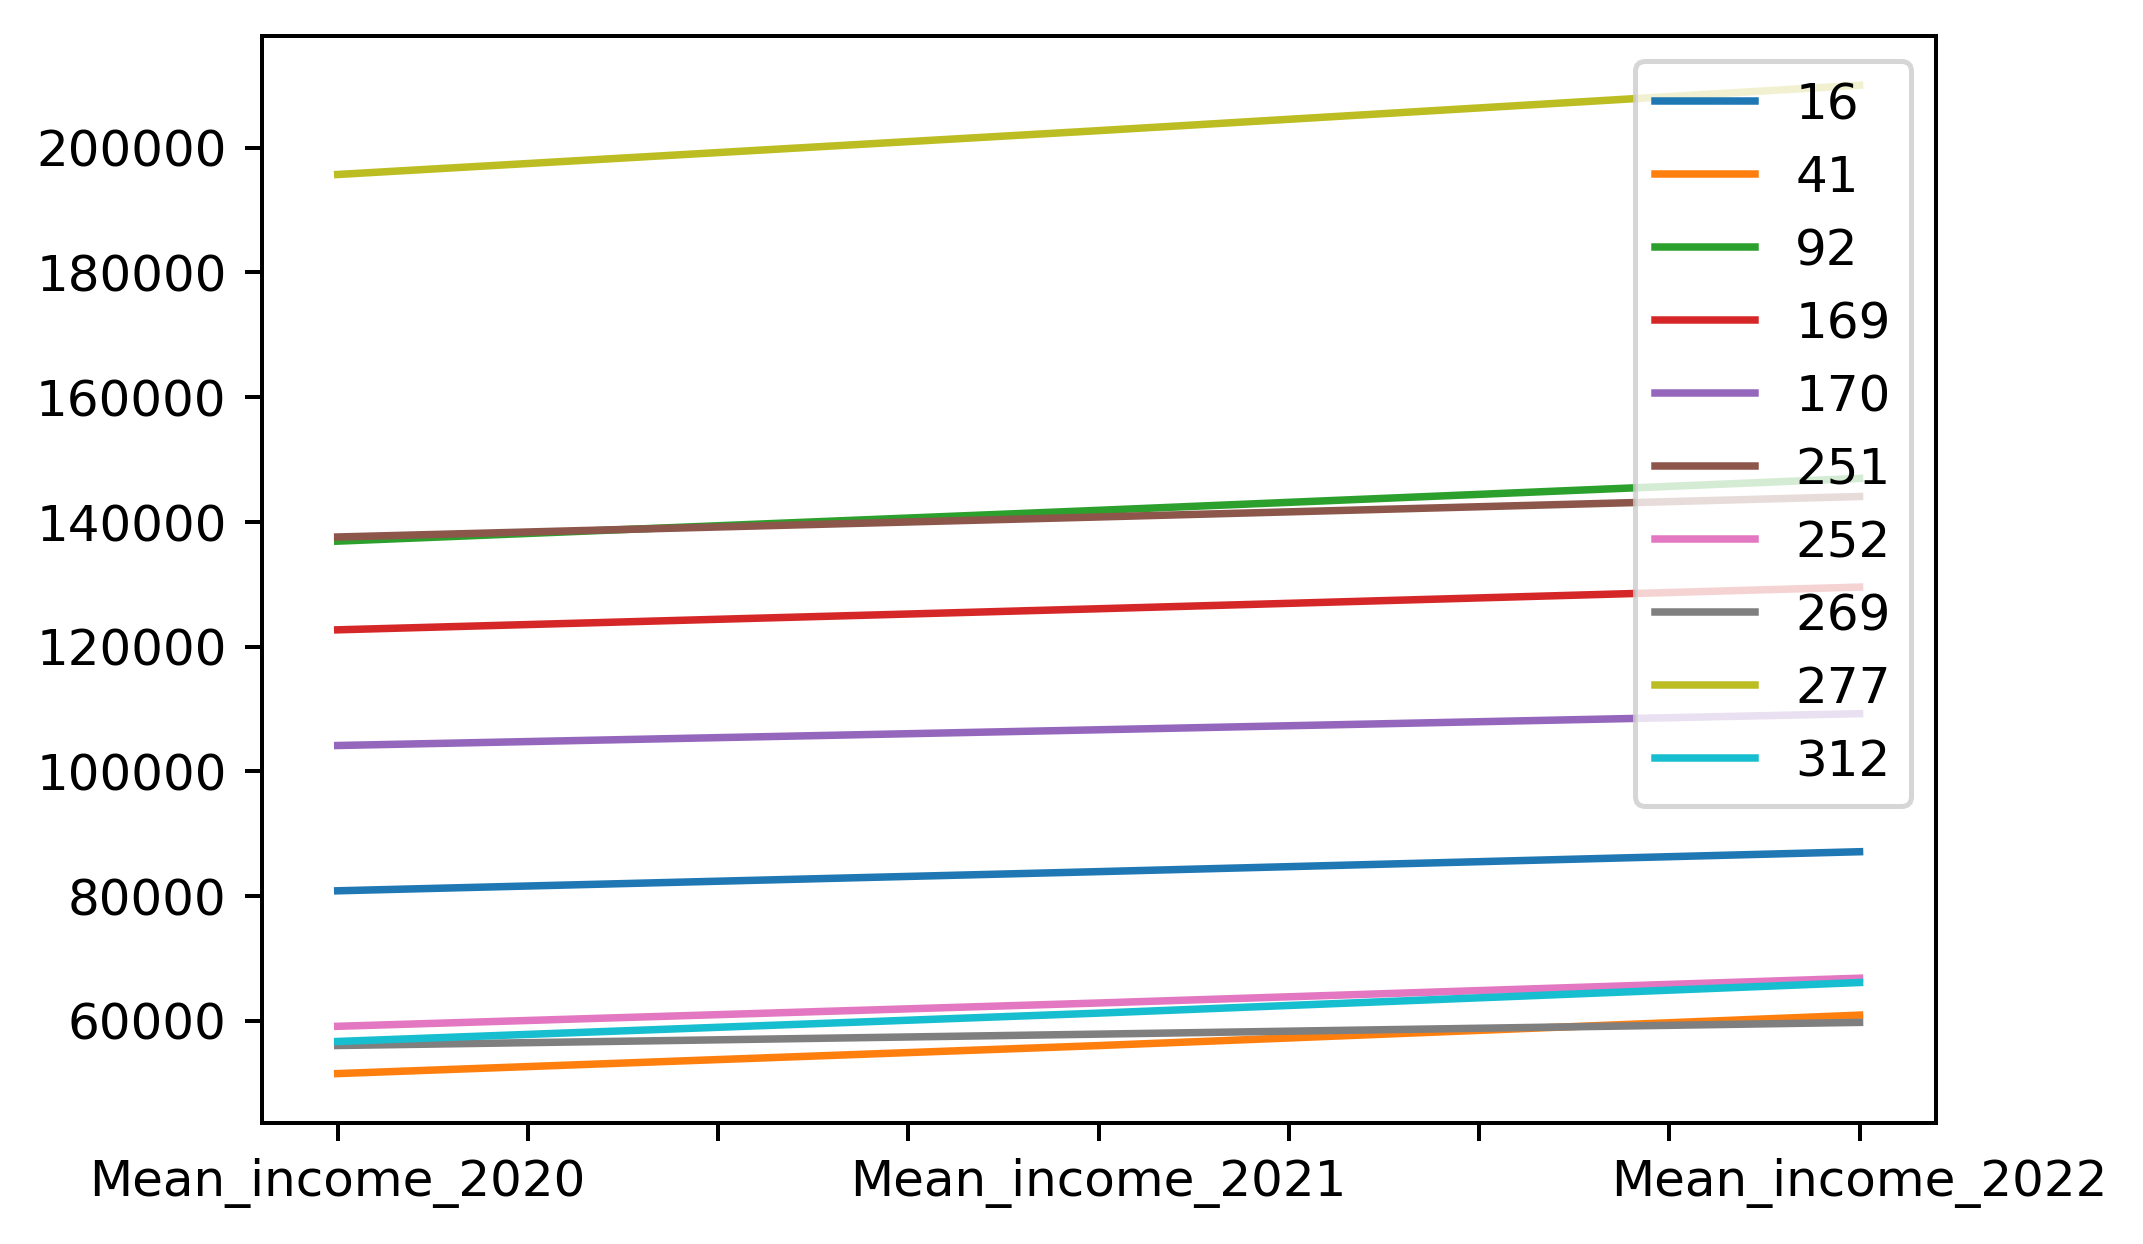

In [210]:
top_ten_income.T.iloc[2:5,].plot()

In [211]:
# sort values to be consistent -> join 2019 data to income data
SA2_data.sort_values(by = ['SA2 name'], inplace = True)
future_income_data.sort_values(by = ['SA2_NAME'], inplace = True)

In [212]:
future_income_data['Mean_income_2019'] = SA2_data['Mean_income']

In [213]:
# get change in income each year
for i in range(2019, 2025): 
    future_income_data['Change from ' + str(i)+' to '+ str(i+1)] = future_income_data['Mean_income_'+ str(i+1)] -  future_income_data['Mean_income_'+ str(i)]


In [214]:
future_income_data

,Unnamed: 0,SA2_NAME,Mean_income_2020,Mean_income_2021,Mean_income_2022,Mean_income_2023,Mean_income_2024,Mean_income_2025,SA2,mean_price,Mean_income_2019,Change from 2019 to 2020,Change from 2020 to 2021,Change from 2021 to 2022,Change from 2022 to 2023,Change from 2023 to 2024,Change from 2024 to 2025
0,0,Abbotsford,81603.0,85174.8,88902.9,92794.2,96855.8,101095.2,Abbotsford,572.679045,78181.0,3422.0,3571.8,3728.1,3891.3,4061.6,4239.4
1,1,Airport West,67662.9,70214.6,72862.5,75610.2,78461.6,81420.5,Airport West,409.000000,65204.0,2458.9,2551.7,2647.9,2747.7,2851.4,2958.9
2,2,Albert Park,122800.0,125235.4,127719.1,130252.0,132835.2,135469.5,Albert Park,700.882353,120412.0,2388.0,2435.4,2483.7,2532.9,2583.2,2634.3
3,3,Alexandra,50193.7,52038.9,53951.9,55935.2,57991.5,60123.3,Alexandra,350.000000,48414.0,1779.7,1845.2,1913.0,1983.3,2056.3,2131.8
4,4,Alfredton,65636.4,67665.6,69757.6,71914.3,74137.6,76429.7,Alfredton,423.421053,63668.0,1968.4,2029.2,2092.0,2156.7,2223.3,2292.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,457,Yarram,49889.2,51292.7,52735.8,54219.5,55744.9,57313.2,Yarram,327.500000,48524.0,1365.2,1403.5,1443.1,1483.7,1525.4,1568.3
310,458,Yarraville,86502.6,90012.0,93663.8,97463.8,101417.9,105532.5,Yarraville,560.571429,83130.0,3372.6,3509.4,3651.8,3800.0,3954.1,4114.6
311,459,Yarrawonga,50606.0,51525.5,52461.6,53414.8,54385.2,55373.4,Yarrawonga,451.666667,49703.0,903.0,919.5,936.1,953.2,970.4,988.2
312,460,Yarriambiack,56678.5,61222.3,66130.4,71431.9,77158.4,83344.0,Yarriambiack,307.500000,52472.0,4206.5,4543.8,4908.1,5301.5,5726.5,6185.6


In [215]:
# predictions to csv
Predictions.to_csv(main_directory +'data/curated/predictions_in_order.csv')